# Car generator (GAN)

## Imports

In [132]:
import torch
import torchvision
from torchvision import datasets, transforms, models
import torch.nn as nn
from torchvision.utils import save_image

import numpy as np

import matplotlib.pyplot as plt

## Loading the dataset

In [90]:
transform = transforms.Compose([
    transforms.Resize(150),
    transforms.CenterCrop((150,200)),
    transforms.ToTensor()
])

dataset_train = datasets.ImageFolder('./dataset/train', transform=transform)
dataset_test = datasets.ImageFolder('./dataset/test', transform=transform)

whole_dataset = torch.utils.data.ConcatDataset([dataset_train, dataset_test])

In [91]:
def show_car(image):
    plt.imshow(image.permute(1,2,0))
    plt.xticks([])
    plt.yticks([])

In [128]:
batch_size = 32

data_loader = torch.utils.data.DataLoader(whole_dataset, batch_size=batch_size,shuffle=True)

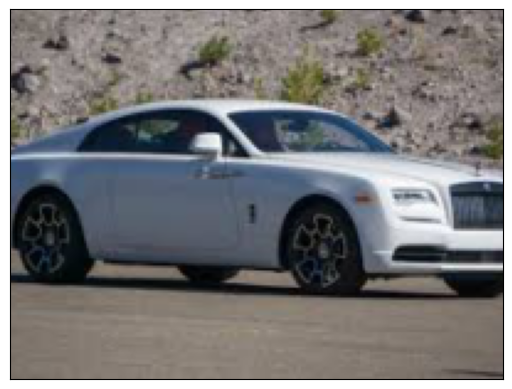

In [131]:
images, _ = next(iter(data_loader))

show_car(images[5])

In [133]:
latent_dim = 64
img_shape = (3, 150, 200)
n_epochs = 100

## Defining the model

In [134]:
class Generator(nn.Module):
    def __init__(self):
        super(Generator, self).__init__()

        def block(in_feat, out_feat, normalize=True):
            layers = [nn.Linear(in_feat, out_feat)]
            if normalize:
                layers.append(nn.BatchNorm1d(out_feat, 0.8))
            layers.append(nn.LeakyReLU(0.2, inplace=True)) # LeakyReLU -> 0.2
            return layers
            
        
        self.model = nn.Sequential(
            *block(latent_dim, 128, normalize=False),
            *block(128, 256),
            *block(256, 512),
            *block(512, 1024),
            nn.Linear(1024, int(np.prod(img_shape))), # np.prod(img_shape) -> 32 * 32 * 1
            nn.Sigmoid(), # output between 0 and 1
        )

    def forward(self, z):
        img = self.model(z)
        return img.view(img.size(0), *img_shape)

In [135]:
class Discriminator(nn.Module):
    def __init__(self):
        super(Discriminator, self).__init__()

        self.model = nn.Sequential(
            nn.Linear(int(np.prod(img_shape)), 512),
            nn.LeakyReLU(0.2),
            nn.Linear(512, 256),
            nn.LeakyReLU(0.2),
            nn.Linear(256, 1),
            nn.Sigmoid()
        )

    def forward(self, img):
        img_flat = img.view(img.size(0), -1)
        return self.model(img_flat)

In [136]:
generator = Generator()
discriminator = Discriminator()

In [137]:
lr = 1e-3
optimizer_G = torch.optim.Adam(generator.parameters(), lr=lr)
optimizer_D = torch.optim.Adam(discriminator.parameters(), lr=lr)

criterion = nn.BCELoss()

In [138]:
for epoch in range(n_epochs):
    for i, (imgs, _) in enumerate(data_loader):

        # Generator training
        optimizer_G.zero_grad()
        
        z = torch.Tensor(np.random.normal(0, 1, (imgs.shape[0], latent_dim))) # random vector sampled form Gaussian distribution
        fake_imgs = generator(z) # fake

        g_loss = criterion(discriminator(fake_imgs), torch.ones(imgs.size(0), 1))

        g_loss.backward()
        optimizer_G.step()

        # Discriminator training

        optimizer_D.zero_grad()

        real_img_loss = criterion(discriminator(imgs), torch.ones(imgs.size(0), 1))
        fake_img_loss = criterion(discriminator(fake_imgs.detach()), torch.zeros(imgs.size(0), 1))

        d_loss = (real_img_loss + fake_img_loss) / 2

        d_loss.backward()
        optimizer_D.step()

    if epoch % 5 == 0:
        print(
            f"[Epoch {epoch}/{n_epochs}] [D loss: {d_loss.item()}] [G loss: {g_loss.item()}]"
        )
        save_image(fake_imgs.data[:25], f"./result/{epoch}.png", nrow=5, normalize=True)

[Epoch 0/100] [D loss: 50.0] [G loss: 0.0]
[Epoch 5/100] [D loss: 50.0] [G loss: 0.0]
[Epoch 10/100] [D loss: 50.0] [G loss: 0.0]
[Epoch 15/100] [D loss: 50.0] [G loss: 0.0]


KeyboardInterrupt: 